# Zeitreihenprognose
Fallstudie: Yahoo Finanzen - Aktinekurs Analyse und Prognose

In [4]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)

# Import the plotting library
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.layers import GRU, Embedding, LSTM

from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [5]:
#!pip install yfinance
import yfinance as yf

Bibliothek von Yahoo Finanzen importieren

In [6]:
#!pip install pandas_datareader
from pandas_datareader import data as wb

[*********************100%***********************]  1 of 1 completed


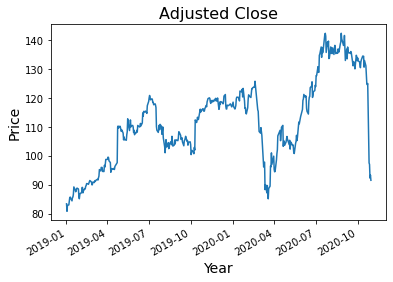

In [7]:
# Get the data of the stock AAPL
sap = yf.download('SAP.DE','2019-01-01','2020-10-31')
# Plot the close price of the AAPL
sap['Adj Close'].plot()
plt.title("Adjusted Close", fontsize=16)
# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.show()

In [6]:
aapl.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-31,39.632500,39.840000,39.119999,39.435001,38.585068,140014000
2019-01-02,38.722500,39.712502,38.557499,39.480000,38.629097,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.781353,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,36.266144,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,36.185429,219111200


In [8]:
sap.describe()

,Open,High,Low,Close,Adj Close,Volume
count,462.000000,462.000000,462.000000,462.000000,462.000000,4.620000e+02
mean,114.294156,115.465563,113.052467,114.323139,111.677667,2.753108e+06
std,13.854389,13.803152,13.749452,13.737599,14.716373,2.076090e+06
min,84.750000,85.760002,82.129997,84.309998,80.784401,6.767630e+05
25%,105.695002,106.804998,104.155001,105.545002,102.492409,1.742606e+06
50%,113.780003,114.930000,112.570000,113.770000,110.479527,2.152338e+06
75%,123.325001,124.135002,122.175001,123.319998,120.180588,2.875072e+06
max,142.800003,143.320007,141.080002,142.259995,142.259995,2.220034e+07


In [9]:
sap.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 462 entries, 2019-01-02 to 2020-10-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       462 non-null    float64
 1   High       462 non-null    float64
 2   Low        462 non-null    float64
 3   Close      462 non-null    float64
 4   Adj Close  462 non-null    float64
 5   Volume     462 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 25.3 KB


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


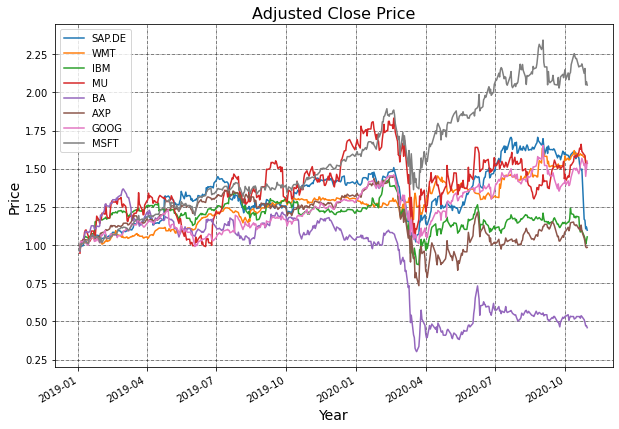

In [10]:
# Define the ticker list
tickers_list = ['SAP.DE', 'WMT', 'IBM', 'MU', 'BA', 'AXP','GOOG','MSFT']

stock_data = pd.DataFrame(columns=tickers_list)
# Fetch the data

for ticker in tickers_list:
    stock_data[ticker] = yf.download(ticker, '2019-1-1', '2020-10-31')['Adj Close']
# Print first 5 rows of the data
#stock_data.head()


# Plot all the close prices
# the cumulative returns for individual stocks
((stock_data.pct_change()+1).cumprod()).plot(figsize=(10, 7))
# Show the legend
plt.legend()
# Define the label for the title of the figure
plt.title("Adjusted Close Price", fontsize=16)
# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)
# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

In [11]:
stock_data.head()

,SAP.DE,WMT,IBM,MU,BA,AXP,GOOG,MSFT
Date,,,,,,,,
2019-01-02,83.371490,90.313919,105.973587,32.750000,314.645142,92.643311,1045.849976,98.860214
2019-01-03,80.784401,89.849495,103.857986,31.000000,302.100555,90.834969,1016.059998,95.223351
2019-01-04,82.825333,90.410690,107.914429,32.700001,317.822601,94.928040,1070.709961,99.652115
2019-01-07,82.997803,91.475037,108.677902,34.000000,318.823395,95.443306,1068.390015,99.779205
2019-01-08,84.291351,92.113625,110.223206,33.740002,330.891937,95.909988,1076.280029,100.502670


In [17]:
#import datetime as dt

start = '2019-1-1'
end = '2020-10-31'

tickers = ['CSCO','AXP','HD','PG']

thelen = len(tickers)

price_data = []
for ticker in tickers:
    prices = wb.DataReader(ticker, start = start, end = end, data_source='yahoo')[['Adj Close']]
    price_data.append(prices.assign(ticker=ticker)[['ticker', 'Adj Close']])

stock_df = pd.concat(price_data)
#stock_df.dtypes
#stock_df.head()
#stock_df.shape

In [18]:
stock_df

,ticker,Adj Close
Date,,
2019-01-02,CSCO,40.382099
2019-01-03,CSCO,38.913486
2019-01-04,CSCO,40.666344
2019-01-07,CSCO,40.941113
2019-01-08,CSCO,41.272739
...,...,...
2020-10-26,PG,141.300003
2020-10-27,PG,142.360001
2020-10-28,PG,137.660004


In [19]:
stock_data.head()

,SAP.DE,WMT,IBM,MU,BA,AXP,GOOG,MSFT
Date,,,,,,,,
2019-01-02,83.371490,90.313919,105.973587,32.750000,314.645142,92.643311,1045.849976,98.860214
2019-01-03,80.784401,89.849495,103.857986,31.000000,302.100555,90.834969,1016.059998,95.223351
2019-01-04,82.825333,90.410690,107.914429,32.700001,317.822601,94.928040,1070.709961,99.652115
2019-01-07,82.997803,91.475037,108.677902,34.000000,318.823395,95.443306,1068.390015,99.779205
2019-01-08,84.291351,92.113625,110.223206,33.740002,330.891937,95.909988,1076.280029,100.502670


In [20]:

start = '2019-1-1'
end = '2020-10-31'

tickers = ['CSCO','AXP','HD','PG']

thelen = len(tickers)

price_data = []
for ticker in tickers:
    prices = wb.DataReader(ticker, start = start, end = end, data_source='yahoo')[['Adj Close']]
    price_data.append(prices.assign(ticker=ticker)[['ticker', 'Adj Close']])

stock_df = pd.concat(price_data)
#stock_df.dtypes
#stock_df.head()
#stock_df.shape

In [21]:
stock_df

,ticker,Adj Close
Date,,
2019-01-02,CSCO,40.382099
2019-01-03,CSCO,38.913486
2019-01-04,CSCO,40.666344
2019-01-07,CSCO,40.941113
2019-01-08,CSCO,41.272739
...,...,...
2020-10-26,PG,141.300003
2020-10-27,PG,142.360001
2020-10-28,PG,137.660004


In [22]:
# Create a pivot table to summarise data
stock_df = stock_df.reset_index()
stock_df = stock_df.set_index('Date')
table = stock_df.pivot(columns='ticker')
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
table.columns = [col[1] for col in table.columns]
table.head()

,AXP,CSCO,HD,PG
Date,,,,
2019-01-02,92.643311,40.382099,164.864197,86.643158
2019-01-03,90.834969,38.913486,161.230515,86.035660
2019-01-04,94.928040,40.666344,166.021240,87.791695
2019-01-07,95.443306,40.941113,169.291534,87.440491
2019-01-08,95.909988,41.272739,170.104340,87.763199


In [23]:
table.shape

(463, 4)

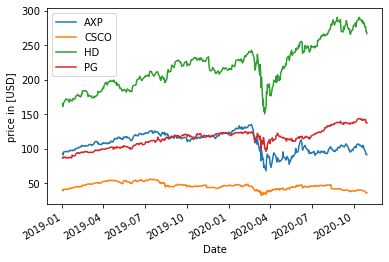

In [24]:
for column in table.columns:
    f = table[column] 
    #f = ((f.pct_change()+1).cumprod())
    f.plot(label=column);
    plt.legend()
    plt.ylabel('price in [USD]')

plt.show()

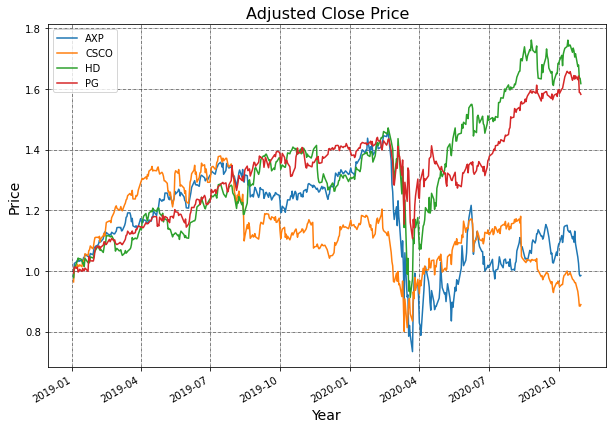

In [25]:
# Plot all the close prices
# the cumulative returns for individual stocks
((table.pct_change()+1).cumprod()).plot(figsize=(10, 7))
# Show the legend
plt.legend()
# Define the label for the title of the figure
plt.title("Adjusted Close Price", fontsize=16)
# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)
# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

In [26]:

stock_data.shape

(462, 8)

<AxesSubplot:xlabel='Date'>

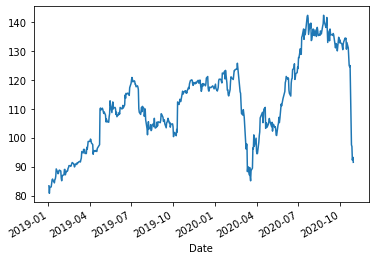

In [27]:
data = stock_data['SAP.DE']
data.plot()

In [28]:
train_df = data[:380]#sap['Adj Close'][:250]
print('train shape:', train_df.shape)
test_df = data[380:]#sap['Adj Close'][250:]
print('test shape: ',test_df.shape)

print("Min x:", np.min(train_df))
print("Max x:", np.max(train_df))

train shape: (380,)
test shape:  (82,)
Min x: 80.7844009399414
Max x: 130.72000122070312


In [29]:
## After this step train and test will become numpy matrices instead of pandas dataframes
## NOTICE: we use the model that is fitted to the train data to scale the test data .. 
## very important to do it this way!

x_scaler = MinMaxScaler()
train = x_scaler.fit_transform(train_df.values.reshape(-1, 1))
test = x_scaler.transform(test_df.values.reshape(-1, 1))

In [30]:
# make sure values are between 0-1
print("Min x:", np.min(train))
print("Max x:", np.max(train))

Min x: 0.0
Max x: 1.0


In [31]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [32]:
seq = [1,2,3,4,5,6,7,8,9,10]
steps = 3
split_sequence(seq,steps)

(array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6],
        [5, 6, 7],
        [6, 7, 8],
        [7, 8, 9]]),
 array([ 4,  5,  6,  7,  8,  9, 10]))

In [33]:
# define input sequence
train #train['Capacity (%)'].values
# choose a number of time steps
n_steps = 5
# split into samples
X_train, y_train = split_sequence(train, n_steps)

In [34]:
X_train

array([[[0.05180852],
        [0.        ],
        [0.04087128],
        [0.04432513],
        [0.07022946]],

       [[0.        ],
        [0.04087128],
        [0.04432513],
        [0.07022946],
        [0.09344739]],

       [[0.04087128],
        [0.04432513],
        [0.07022946],
        [0.09344739],
        [0.09843626]],

       ...,

       [[0.80134417],
        [0.82777821],
        [0.83418646],
        [0.87183489],
        [0.86262305]],

       [[0.82777821],
        [0.83418646],
        [0.87183489],
        [0.86262305],
        [0.93872112]],

       [[0.83418646],
        [0.87183489],
        [0.86262305],
        [0.93872112],
        [0.93711902]]])

In [35]:
# define test sequence
#test_raw_seq = test #test['Capacity (%)'].values
# choose a number of time steps .. same as training!
#n_steps = 5
# split into samples
X_test, y_test = split_sequence(test, n_steps)
#X_test.shape

In [36]:
print(X_train.shape)
print(X_test.shape)

(375, 5, 1)
(77, 5, 1)


In [ ]:
n_features = 1

# define model
model = Sequential()

# Single layer GRU
#model.add(GRU(32 , input_shape=(n_steps, n_features) ))

# Stacked GRU
#model.add(GRU(8 , input_shape=(n_steps, n_features) , return_sequences=True))
#model.add(GRU(16, return_sequences=True))
#model.add(GRU(32))

# Stacked LSTM
model.add(LSTM(8, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(LSTM(16, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu'))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=1, callbacks=[es, mc])

# fit model
#model.fit(X_train, y_train, epochs=50, verbose=1, callbacks=[es, mc])

Train on 300 samples, validate on 75 samples
Epoch 1/100


In [32]:
history.history

{'val_loss': [0.16726338724295298,
  0.13471570094426474,
  0.08856752117474874,
  0.03523713511725267,
  0.016778073540578285,
  0.06120877578854561,
  0.024108169302344322,
  0.023465490676462652,
  0.03423056155443192,
  0.028458607519666355,
  0.027329651166995365,
  0.027219153369466464,
  0.025983465587099394,
  0.02514879102508227,
  0.024287778101861477,
  0.023791003227233886,
  0.02220486957579851,
  0.021439013220369816,
  0.020797490142285824,
  0.019173737714687982,
  0.019261505206425986,
  0.017203363726536434,
  0.01691839228073756,
  0.015746429624656836,
  0.015163956731557847,
  0.014138110857456922,
  0.014579398930072785,
  0.012378611384580534,
  0.013929663710296154,
  0.012133850542207558,
  0.013038406254102786,
  0.01216893723855416,
  0.0118064234405756,
  0.01187934554492434,
  0.012485640154530605,
  0.011270179568479458,
  0.012008830277870098,
  0.011836357824504375,
  0.011361571798721949,
  0.011746525360892216,
  0.012084357365965843,
  0.0105575360792

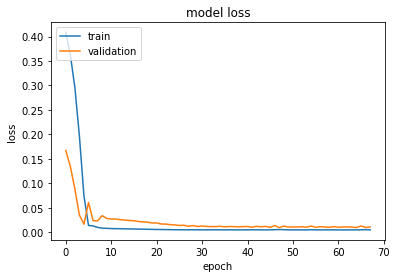

In [33]:
## visualise performance (training loss vs validation loss)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [34]:
n_features = 1
# define model
model = Sequential()
#model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X_train, y_train, epochs=20, verbose=1)

Epoch 1/20
375/375 [==============================] - 1s 4ms/step - loss: 0.1959
Epoch 2/20
375/375 [==============================] - 0s 213us/step - loss: 0.0123
Epoch 3/20
375/375 [==============================] - 0s 199us/step - loss: 0.0127
Epoch 4/20
375/375 [==============================] - 0s 213us/step - loss: 0.0061
Epoch 5/20
375/375 [==============================] - 0s 210us/step - loss: 0.0057
Epoch 6/20
375/375 [==============================] - 0s 189us/step - loss: 0.0052
Epoch 7/20
375/375 [==============================] - 0s 214us/step - loss: 0.0048
Epoch 8/20
375/375 [==============================] - 0s 211us/step - loss: 0.0044
Epoch 9/20
375/375 [==============================] - 0s 202us/step - loss: 0.0043
Epoch 10/20
375/375 [==============================] - 0s 223us/step - loss: 0.0041
Epoch 11/20
375/375 [==============================] - 0s 227us/step - loss: 0.0041
Epoch 12/20
375/375 [==============================] - 0s 252us/step - loss: 0.0040
Epo

In [36]:
from keras.models import load_model

# load the saved model
model = load_model('best_model.h5')

In [37]:
def rmse(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred - y_true)))

In [39]:
preds = []
# demonstrate predictions
for i in range(X_test.shape[0]):
    x_input = X_test[i]
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    preds.append(yhat[0])
    #print(yhat[0], y_test[i])

In [40]:
# The output of the model is between 0 and 1.
# Do an inverse map to get it back to the scale
# of the original data-set.
preds   = x_scaler.inverse_transform(np.array(preds))
# we also rescale the y_test values into their original range (inverse scaling)
actuals = x_scaler.inverse_transform(y_test)

In [41]:
rmse(actuals, preds)

3.60253119618687

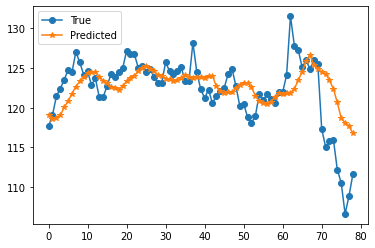

In [42]:

# multiple line plot
plt.plot(actuals, marker='o', label='True')
plt.plot(preds, marker='*', label='Predicted')

plt.legend()